<a href="https://colab.research.google.com/github/Frynnn-69/mini-research-bdc2025/blob/main/src/02_data_processing/02_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

repo_path = '/content/drive/My Drive/mini-research-bdc2025/'
os.chdir(repo_path)
!git pull

# --- CHANGE PATH ---
notebook_folder = '/content/drive/MyDrive/mini-research-bdc2025/src/02_data_processing/'

working_dir = os.path.join(repo_path, notebook_folder)
os.chdir(working_dir)

!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 5), reused 6 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (10/10), 481.90 KiB | 339.00 KiB/s, done.
From https://github.com/frynnn-69/mini-research-bdc2025
   d9e5bb3..519842f  main       -> origin/main
Updating f68d558..519842f
error: Your local changes to the following files would be overwritten by merge:
	src/02_data_processing/02_data_pipeline.ipynb
Please commit your changes or stash them before you merge.
error: The following untracked working tree files would be overwritten by merge:
	src/02_data_processing/datatrain_augmented.csv
Please move or remove them before you merge.
Aborting
/content/drive/MyDrive/mini-research-bdc2025/src/02_data_processing


In [2]:
!pip install -q yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.3 MB/s eta 0:00:00


In [3]:
import pandas as pd

csv_path = 'datatrain_final.csv'

try:
    df = pd.read_csv(csv_path)
    print(f"{len(df)} Video")
    display(df.head())
except FileNotFoundError as e:
  print(e)

755 Video


,id,video,emotion
0,1,https://www.instagram.com/reel/DNKcHgdA-d1/?ig...,Surprise
1,2,https://www.instagram.com/reel/DNHwrh2gnBm/?ig...,Surprise
2,3,https://www.instagram.com/reel/DM7QsjnRCoa/?ig...,Surprise
3,4,https://www.instagram.com/reel/DNBBEt6Paxj/?ig...,Surprise
4,5,https://www.instagram.com/reel/DMz13fQzZsN/?ig...,Proud


# Download and Extract (Vid & Aud)

In [4]:
import os
import subprocess
import time
import random

cookies_file_path = '/cookies.txt'
if not os.path.exists(cookies_file_path):
    print("File 'cookies.txt' not found!")
else:
    print("File 'cookies.txt' was found!")

    base_storage_path = '/content/drive/My Drive/BDC_DATASET/'
    video_train_path = os.path.join(base_storage_path, 'videos', 'train')
    os.makedirs(video_train_path, exist_ok=True)
    print(f"The video will be saved in: {video_train_path}")
    print("-" * 30)

    for index, row in df.iterrows():
        video_id = row['id']
        video_url = row['video']

        output_template = os.path.join(video_train_path, f"video_{video_id}.%(ext)s")

        if any(fname.startswith(f"video_{video_id}.") for fname in os.listdir(video_train_path)):
            continue

        command = f"yt-dlp -q --cookies '{cookies_file_path}' -f 'bv*[ext=mp4]+ba[ext=m4a]/b[ext=mp4] / bv*+ba/b' -o '{output_template}' '{video_url}'"

        try:
            subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
            print(f"Video ID {video_id}: Downloaded successfully.")
        except subprocess.CalledProcessError as e:
            error_lines = e.stderr.strip().split('\n')
            print(f"Video ID {video_id}: Failed. Error: {error_lines[-1]}")

        sleep_time = random.uniform(1, 5)
        time.sleep(sleep_time)

File 'cookies.txt' not found!


In [8]:
# Extract Audio
from tqdm.auto import tqdm

video_train_path = '/content/drive/My Drive/BDC_DATASET/videos/train'
audio_train_path = '/content/drive/My Drive/BDC_DATASET/audio/train'
os.makedirs(audio_train_path, exist_ok=True)

print(f"The audio will be saved in: {audio_train_path}")
print("-" * 30)

video_files = os.listdir(video_train_path)

for video_filename in tqdm(video_files, desc="Extracting Audio"):
    source_video_path = os.path.join(video_train_path, video_filename)

    base_filename = os.path.splitext(video_filename)[0]
    output_audio_path = os.path.join(audio_train_path, f"{base_filename.replace('video_', 'audio_')}.wav")

    if os.path.exists(output_audio_path):
        continue

    command = f"ffmpeg -i '{source_video_path}' -vn -acodec pcm_s16le -ar 16000 -ac 1 '{output_audio_path}'"

    try:
        subprocess.run(command, shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e:
        print(f"Failed to extract audio from: {video_filename}")

The audio will be saved in: /content/drive/My Drive/BDC_DATASET/audio/train
------------------------------


Extracting Audio:   0%|          | 0/752 [00:00<?, ?it/s]

# Data Augmentation - v1 (RAVDESS)

In [5]:
import os
import requests
import zipfile
from tqdm import tqdm

url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
zip_path = "ravdess_audio.zip"
extract_path = "ravdess_speech_audio"

if not os.path.exists(extract_path):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
        with open(zip_path, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("Download incomplete.")
        else:
            print("Download complete.")

            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

            os.remove(zip_path)

    except requests.exceptions.RequestException as e:
        print(f"{e}")

else:
    print(f"RAVDESS dataset is already '{extract_path}'.")

RAVDESS dataset is already 'ravdess_speech_audio'.


In [7]:
import pandas as pd
import os

ravdess_data = []
ravdess_directory = "ravdess_speech_audio"

emotion_map = {
    "01": "Neutral",
    "04": "Sadness",
    "05": "Anger",
    "06": "Fear"
}

for actor_folder in sorted(os.listdir(ravdess_directory)):
    actor_path = os.path.join(ravdess_directory, actor_folder)

    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith(".wav"):
                parts = file_name.split("-")

                modality_code = parts[0]
                vocal_channel_code = parts[1]
                emotion_code = parts[2]

                is_audio_only = (modality_code == "03")
                is_speech = (vocal_channel_code == "01")
                is_target_emotion = (emotion_code in emotion_map)

                if is_audio_only and is_speech and is_target_emotion:
                    emotion_label = emotion_map[emotion_code]
                    file_path = os.path.join(actor_path, file_name)
                    ravdess_data.append({
                        "emotion": emotion_label,
                        "audio_path": file_path
                    })

df_ravdess_filtered = pd.DataFrame(ravdess_data)

print(f"\n{len(df_ravdess_filtered)} relevant audio files.")
display(df_ravdess_filtered.head())

print("\nDistribution of emotions (RAVDESS):")
print(df_ravdess_filtered['emotion'].value_counts())


672 relevant audio files.


,emotion,audio_path
0,Neutral,ravdess_speech_audio/Actor_01/03-01-01-01-01-0...
1,Neutral,ravdess_speech_audio/Actor_01/03-01-01-01-01-0...
2,Neutral,ravdess_speech_audio/Actor_01/03-01-01-01-02-0...
3,Neutral,ravdess_speech_audio/Actor_01/03-01-01-01-02-0...
4,Sadness,ravdess_speech_audio/Actor_01/03-01-04-01-01-0...



Distribution of emotions (RAVDESS):
emotion
Sadness    192
Anger      192
Fear       192
Neutral     96
Name: count, dtype: int64


## Data Sanity Check

In [ ]:
audio_train_path = '/content/drive/My Drive/BDC_DATASET/audio/train'
df['audio_path'] = df['id'].apply(lambda x: os.path.join(audio_train_path, f'audio_{x}.wav'))

df_original_subset = df[['emotion', 'audio_path']].copy()
df_augmented = pd.concat([df_original_subset, df_ravdess], ignore_index=True)

print("================ Comparison of Emotion Distributions ================")
print("\nData Train Final (BDC):")
print(df_original_subset['emotion'].value_counts())

print("\n------------------------------------------------------------")

print("\nData Augmentation (BDC + RAVDESS):")
print(df_augmented['emotion'].value_counts())

print(f"\nTotal: {len(df_augmented)} row. ('{augmented_csv_path}')")

augmented_csv_path = "datatrain_augmented.csv"
df_augmented.to_csv(augmented_csv_path, index=False)

================ Comparison of Emotion Distributions ================

Data Train Final (BDC):
emotion
Surprise    316
Trust       165
Proud       149
Joy          52
Anger        36
Sadness      16
Fear         15
Neutral       6
Name: count, dtype: int64

------------------------------------------------------------

Data Augmentation (BDC + RAVDESS):
emotion
Surprise    316
Anger       228
Sadness     208
Fear        207
Trust       165
Proud       149
Neutral     102
Joy          52
Name: count, dtype: int64

Total: 1427 row. ('datatrain_augmented.csv')


In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Audio
import random

audio_train_path = '/content/drive/My Drive/BDC_DATASET/audio/train'
df['audio_path'] = df['id'].apply(lambda x: os.path.join(audio_train_path, f'audio_{x}.wav'))
df_original_subset = df[['emotion', 'audio_path']].copy()

df_augmented_v2 = pd.concat([df_original_subset, df_ravdess_filtered], ignore_index=True)

augmented_csv_path_v2 = "datatrain_augmented_v2.csv"
df_augmented_v2.to_csv(augmented_csv_path_v2, index=False)

,Before Augmentation,After Augmentation (v2),Improvement
emotion,,,
Anger,36,228,192
Fear,15,207,192
Joy,52,52,0
Neutral,6,102,96
Proud,149,149,0
Sadness,16,208,192
Surprise,316,316,0
Trust,165,165,0


/tmp/ipython-input-2531789827.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='emotion', data=df_augmented_v2, order=df_augmented_v2['emotion'].value_counts().index, palette='viridis')


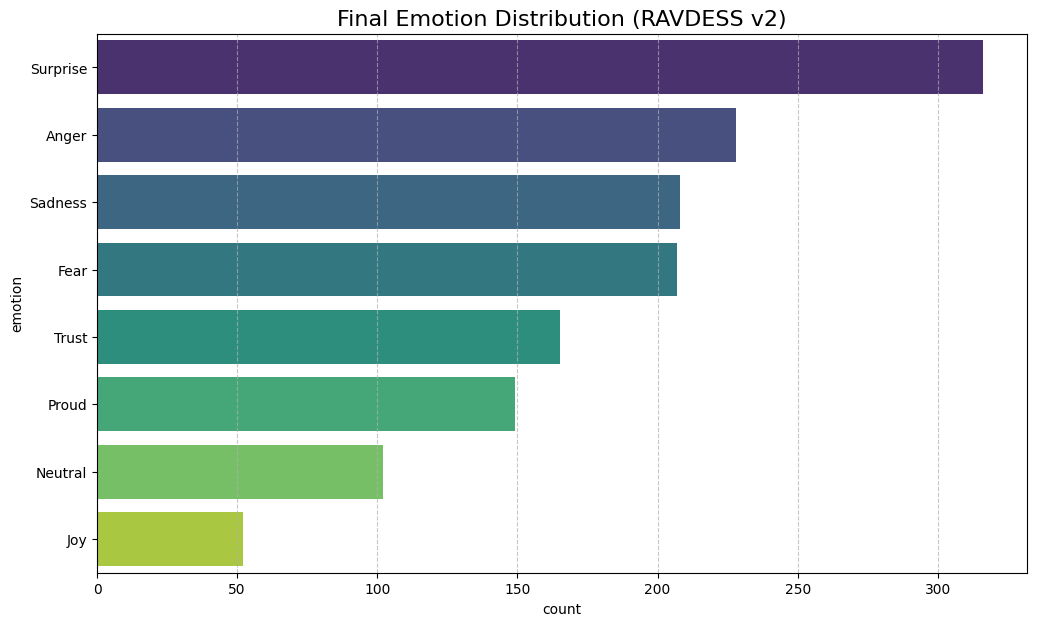

from matplotlib import pyplot as plt
df_comparison['Before Augmentation'].plot(kind='hist', bins=20, title='Before Augmentation')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparison['After Augmentation (v2)'].plot(kind='hist', bins=20, title='After Augmentation (v2)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparison['Improvement'].plot(kind='hist', bins=20, title='Improvement')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparison.plot(kind='scatter', x='Before Augmentation', y='After Augmentation (v2)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparison.plot(kind='scatter', x='After Augmentation (v2)', y='Improvement', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_comparison['Before Augmentation'].plot(kind='line', figsize=(8, 4), title='Before Augmentation')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_comparison['After Augmentation (v2)'].plot(kind='line', figsize=(8, 4), title='After Augmentation (v2)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_comparison['Improvement'].plot(kind='line', figsize=(8, 4), title='Improvement')
plt.gca().spines[['top', 'right']].set_visible(False)

In [17]:
dist_before = df_original_subset['emotion'].value_counts()
dist_after = df_augmented_v2['emotion'].value_counts()
df_comparison = pd.DataFrame({'Before Augmentation': dist_before, 'After Augmentation (v2)': dist_after}).fillna(0).astype(int)
df_comparison['Improvement'] = df_comparison['After Augmentation (v2)'] - df_comparison['Before Augmentation']
display(df_comparison)

plt.figure(figsize=(12, 7))
sns.countplot(y='emotion', data=df_augmented_v2, order=df_augmented_v2['emotion'].value_counts().index, palette='viridis')
plt.title('Final Emotion Distribution (RAVDESS v2)', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [16]:
ravdess_samples = df_ravdess_filtered.sample(n=3, random_state=42)

for index, row in ravdess_samples.iterrows():
    print(f"\nEmotion Labels: {row['emotion']}")
    display(Audio(row['audio_path']))


Emotion Labels: Fear



Emotion Labels: Anger



Emotion Labels: Sadness
